In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
# first we must investigate to see which table has the column 'date' 

In [10]:
inspector = inspect(engine)

columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

# above displays that the column 'date' lives in the measurement table

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Find the most recent date in the data set.

# total dates found:
session.query(func.count(measurement.date)).all()       # total dates: 19550

# find the latest date:
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()       # the most recent date is ('2017-08-23')
print(f"Most Recent Date: {most_recent_date}")

Most Recent Date: ('2017-08-23',)


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

one_year = dt.date(2017,8,23) - dt.timedelta(days = 365)
print(f"Date One Year Ago: {one_year}")

# Calculate the date one year from the last date in data set.

last_date = dt.date(one_year.year, one_year.month, one_year.day)
print(f"One year from {most_recent_date}: {last_date}")

# Perform a query to retrieve the data and precipitation scores

scores = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= '2016-08-23').\
    filter(measurement.date <= '2017-08-23').order_by(measurement.date).all()
scores
# Save the query results as a Pandas DataFrame. Explicitly set the column names

scores_df = pd.DataFrame(scores, columns = ['Date','Precipitation']).set_index('Date')
scores_df

# Sort the dataframe by date
prcp_df = scores_df.sort_values(by="Date").dropna()
prcp_df.head()




Date One Year Ago: 2016-08-23
One year from ('2017-08-23',): 2016-08-23


,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


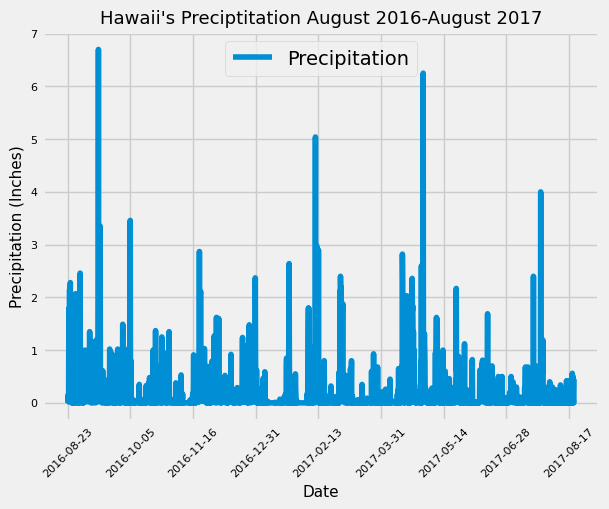

In [28]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot()

plt.xlabel("Date",size = 11)
plt.ylabel("Precipitation (Inches)", size = 11)
plt.title("Hawaii's Preciptitation August 2016-August 2017",size = 13)
plt.legend(["Precipitation"],loc="best")
plt.xticks(rotation = 45, size = 8)
plt.yticks(size = 8)

plt.show()

In [29]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [32]:
# Design a query to calculate the total number of stations in the dataset
# count_stations = session.query(station.id).count()
# count_stations

session.query(station.id).count()

9

In [35]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [37]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_id = "USC00519281"
session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).\
    filter(measurement.station == station_id).all()

[(54.0, 85.0, 71.66378066378067)]

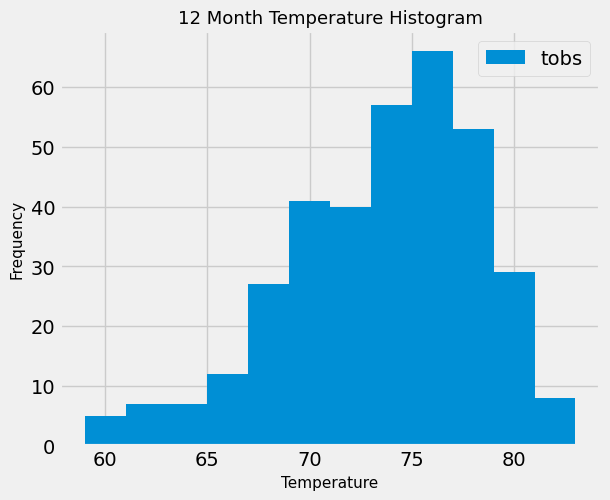

In [43]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_query = session.query(measurement.date, measurement.tobs).\
    filter(measurement.date >= '2016-08-23').\
    filter(measurement.date <= '2017-08-23').\
    filter(measurement.station == station_id).order_by(measurement.date).all()

temp_df = pd.DataFrame(temp_query)

temp_df.plot.hist(bins=12)
plt.tight_layout()
plt.xlabel("Temperature",size = 11)
plt.ylabel("Frequency", size = 11)
plt.title("12 Month Temperature Histogram",size = 13)
plt.legend(["tobs"],loc="best")
plt.show()

# Close Session

In [44]:
# Close Session
session.close()